# Madrid Houding Demo, 2020 version on CP4D

Madrid Housing Prices Steps

1. Data Preparations
2. Feature Engineering
3. Exploration (Plots)
4. Model Training
5. Evaluation
6. Model Deployment


---

## Installing Libraries

In [1]:
%%capture INSTALL_FOLIUM
!pip install folium

In [2]:
import folium

In [3]:
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb

## 1 - Data Preparations

In [4]:
madrid_data = pd.read_csv('/project_data/data_asset/madrid_houses_v5.csv', parse_dates=['create_date'], infer_datetime_format=True )
madrid_data.head()

ad_id     price  region_level2_id      lat      lng  \
0  141537319.0  550000.0              28.0  40.4040 -3.69258   
1  141129777.0   84999.0              28.0  40.4212 -3.61754   
2  141321296.0  159999.0              28.0  40.4226 -3.64750   
3  142917234.0  515000.0              28.0  40.4429 -3.71124   
4  141506865.0  115000.0              28.0  40.3796 -3.73910   

          create_date property property_state  district_id   mts2  ...  \
0 2017-02-22 13:15:54     Flat       VeryGood        671.0  178.0  ...   
1 2017-01-17 19:37:03     Flat            NaN        676.0   60.0  ...   
2 2017-02-02 18:53:29     Flat            NaN        685.0   67.0  ...   
3 2017-06-15 07:43:11     Flat           Good        177.0  139.0  ...   
4 2017-02-20 13:00:42     Flat            NaN        171.0   56.0  ...   

   pista-tenis sauna  piscina-comunitaria  puerta-blindada  terraza lavadora  \
0            0     0                    0                0        1        0   
1            0     0                    0                0        0        0   
2            0     0                    0                0        0        0   
3            0     0                    0                0        0        0   
4            0     0                    0                1        0        0   

   serv-porteria  zona-infantil  cocina-office parking-comunitario  
0              1              0              0                   0  
1              0              0              0                   0  
2              0              0              0                   0  
3              0              0              0                   0  
4              0              0              0                   0  

[5 rows x 92 columns]

In [5]:
madrid_with_price = madrid_data[ (madrid_data["price"] > 30.000) & (madrid_data["mts2"] > 30.0) ]
madrid_with_price.head()

ad_id     price  region_level2_id      lat      lng  \
0  141537319.0  550000.0              28.0  40.4040 -3.69258   
1  141129777.0   84999.0              28.0  40.4212 -3.61754   
2  141321296.0  159999.0              28.0  40.4226 -3.64750   
3  142917234.0  515000.0              28.0  40.4429 -3.71124   
4  141506865.0  115000.0              28.0  40.3796 -3.73910   

          create_date property property_state  district_id   mts2  ...  \
0 2017-02-22 13:15:54     Flat       VeryGood        671.0  178.0  ...   
1 2017-01-17 19:37:03     Flat            NaN        676.0   60.0  ...   
2 2017-02-02 18:53:29     Flat            NaN        685.0   67.0  ...   
3 2017-06-15 07:43:11     Flat           Good        177.0  139.0  ...   
4 2017-02-20 13:00:42     Flat            NaN        171.0   56.0  ...   

   pista-tenis sauna  piscina-comunitaria  puerta-blindada  terraza lavadora  \
0            0     0                    0                0        1        0   
1            0     0                    0                0        0        0   
2            0     0                    0                0        0        0   
3            0     0                    0                0        0        0   
4            0     0                    0                1        0        0   

   serv-porteria  zona-infantil  cocina-office parking-comunitario  
0              1              0              0                   0  
1              0              0              0                   0  
2              0              0              0                   0  
3              0              0              0                   0  
4              0              0              0                   0  

[5 rows x 92 columns]

In [6]:
print("A total of ", madrid_with_price.count()[0], " houses are available in the data set.")

A total of  16161  houses are available in the data set.


## Heatmap of Data with Folium

In [7]:
import folium

cybele_palace = (40.418906, -3.692084)

lat_lng_list = list( zip( list(madrid_with_price.lat), list(madrid_with_price.lng) ) )
house_density = [ (lat,lng,0.3) for (lat,lng) in lat_lng_list ]
centre_madrid = cybele_palace

from folium.plugins import HeatMap

map_with_houses = folium.Map(centre_madrid, tiles='stamentoner', zoom_start=11)

HeatMap(house_density).add_to(map_with_houses)
map_with_houses

## A Classic Linear Regression on the size of property to predict the price

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [8]:
import numpy as np
from sklearn import datasets, linear_model

x = madrid_with_price["mts2"].to_frame()
y = madrid_with_price["price"].to_frame()

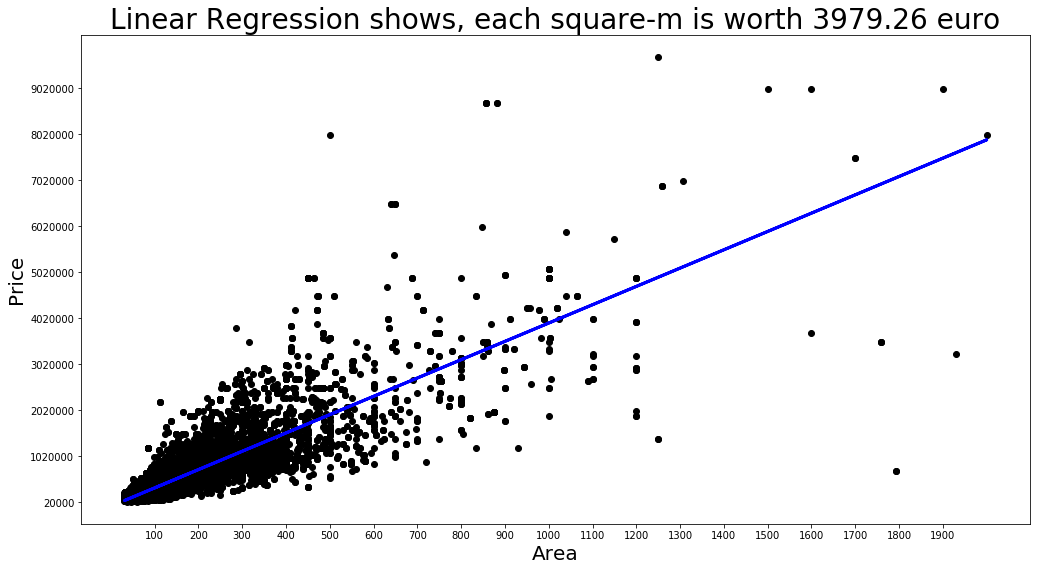

In [9]:
%matplotlib inline  
import matplotlib.pyplot as plt

regr = linear_model.LinearRegression()
regr.fit(x, y)

# plot it as in the example at http://scikit-learn.org/
plt.figure(figsize=(17, 9))
title = "Linear Regression shows, each square-m is worth {0:.2f} euro".format( regr.coef_.flatten()[0] )
plt.title(title, fontsize=28) 
plt.scatter(x.values, y.values,  color='black')
plt.xticks((np.arange(100,2000,100)))
plt.yticks((np.arange(20000,10000000,1000000)))
plt.xlabel('Area', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.plot(x, regr.predict(x), color='blue', linewidth=3)

plt.show()

In [10]:
y_true = madrid_with_price["price"].to_frame()
y_pred = regr.predict(madrid_with_price["mts2"].to_frame())

In [11]:
regression_MSE = sklearn.metrics.mean_squared_error(y_true, y_pred)
rmse_lm = np.sqrt(regression_MSE)

In [12]:
print(" The RSME for the Linear Model is {}".format(rmse_lm))

 The RSME for the Linear Model is 374323.27660223434


## 2. Feature Engineering

### Feature Engineering - Add `distance_to_centre` as new Column

In [13]:
import geopy
from geopy.distance import great_circle

puerta_del_sol = (40.416920, -3.703479)

def distance_to_puerta_del_sol(lat, lng):
    global puerta_del_sol
    return great_circle( (lat,lng), puerta_del_sol ).km

cybele_palace = (40.418906, -3.692084)
print( "The distance (KM) from Cybele Palace, to Puerta del Sol is {0:.2f} KM".format( distance_to_puerta_del_sol(*cybele_palace) ) )

The distance (KM) from Cybele Palace, to Puerta del Sol is 0.99 KM


In [14]:
distance_to_centre_series = madrid_with_price.apply( lambda x : distance_to_puerta_del_sol(x.lat , x.lng) , axis=1)
distance_to_centre_df = distance_to_centre_series.to_frame(name="distance_to_centre")
distance_to_centre_df.head(5)

distance_to_centre
0            1.707470
1            7.290744
2            4.780775
3            2.962595
4            5.130278

In [15]:
madrid_with_centre = madrid_with_price.join(distance_to_centre_df)
madrid_with_centre[["ad_id","price","lat","lng","create_date","distance_to_centre","mts2"]].head(5)

ad_id     price      lat      lng         create_date  \
0  141537319.0  550000.0  40.4040 -3.69258 2017-02-22 13:15:54   
1  141129777.0   84999.0  40.4212 -3.61754 2017-01-17 19:37:03   
2  141321296.0  159999.0  40.4226 -3.64750 2017-02-02 18:53:29   
3  142917234.0  515000.0  40.4429 -3.71124 2017-06-15 07:43:11   
4  141506865.0  115000.0  40.3796 -3.73910 2017-02-20 13:00:42   

   distance_to_centre   mts2  
0            1.707470  178.0  
1            7.290744   60.0  
2            4.780775   67.0  
3            2.962595  139.0  
4            5.130278   56.0

## 3. Exploration (Plots)

### Feature Engineering - Lat / Long, & Metro Stations in Madrid

We can add more features, like the distance to the closest metro station

![](https://s-media-cache-ak0.pinimg.com/originals/eb/8d/e5/eb8de521b72848827903a35a2e9ceca9.jpg)

In [16]:
metros_in_madrid = pd.read_csv('/project_data/data_asset/unique_metro_v5.csv')
metros_in_madrid.head()


0             Pacífico (Madrid Metro)   40.40126  -3.6751312000000005
0  1  Sierra de Guadalupe (Madrid Metro)  40.382164            -3.624719
1  2               Atocha (Madrid Metro)  40.408851            -3.692484
2  3             Portazgo (Madrid Metro)  40.392661            -3.658679
3  4               Bilbao (Madrid Metro)  40.429054            -3.702182
4  5         Antón Martín (Madrid Metro)  40.412468            -3.699369

In [17]:
metros_in_madrid.columns = ["id","station","latitude","longitude"]
metros_in_madrid = metros_in_madrid[ metros_in_madrid["latitude"] > 39.5 ]
metros_in_madrid.head()

id                             station   latitude  longitude
0   1  Sierra de Guadalupe (Madrid Metro)  40.382164  -3.624719
1   2               Atocha (Madrid Metro)  40.408851  -3.692484
2   3             Portazgo (Madrid Metro)  40.392661  -3.658679
3   4               Bilbao (Madrid Metro)  40.429054  -3.702182
4   5         Antón Martín (Madrid Metro)  40.412468  -3.699369

### Again, we can use Folium to make pretty maps of the Metro Stations in Madrid

In [18]:
import folium

map_osm = folium.Map(location=[np.mean(metros_in_madrid.latitude), np.mean(metros_in_madrid.longitude)])
for i in range(metros_in_madrid.id.count()):
    row = metros_in_madrid.iloc[i]
    folium.Marker([row.latitude, row.longitude]).add_to(map_osm)
    
map_osm

Zoom in to take a look at where the metros are.

### Determine distance from our favourite reference location to the nearest metro station
We do this by defining a function which uses the locations of all the metros, the call the functions with our favourite Cybele Palace location 

In [19]:
from sklearn.neighbors import DistanceMetric

dist = DistanceMetric.get_metric('haversine')

houses_gps = madrid_with_centre[["lat", "lng"]].values
metro_gps = metros_in_madrid[["latitude", "longitude"]].values

In [20]:
EARTH_RADIUS = 6371.009

haversine_distances = dist.pairwise(np.radians(houses_gps), np.radians(metro_gps) )
haversine_distances *= EARTH_RADIUS

In [21]:
madrid_with_centre["distance_to_metro"] = np.min(haversine_distances,axis=1) 

### Feature Engineering - Make Data more colorful, reflect certain aspect more prominent in the data
If we join the results of the distance calculation with the original data we can show the distance to a metro station

In [22]:
madrid_with_metro = madrid_with_centre.copy()
madrid_with_metro.head(3)

ad_id     price  region_level2_id      lat      lng  \
0  141537319.0  550000.0              28.0  40.4040 -3.69258   
1  141129777.0   84999.0              28.0  40.4212 -3.61754   
2  141321296.0  159999.0              28.0  40.4226 -3.64750   

          create_date property property_state  district_id   mts2  ...  \
0 2017-02-22 13:15:54     Flat       VeryGood        671.0  178.0  ...   
1 2017-01-17 19:37:03     Flat            NaN        676.0   60.0  ...   
2 2017-02-02 18:53:29     Flat            NaN        685.0   67.0  ...   

   piscina-comunitaria puerta-blindada  terraza  lavadora  serv-porteria  \
0                    0               0        1         0              1   
1                    0               0        0         0              0   
2                    0               0        0         0              0   

  zona-infantil  cocina-office  parking-comunitario  distance_to_centre  \
0             0              0                    0            1.707470   
1             0              0                    0            7.290744   
2             0              0                    0            4.780775   

  distance_to_metro  
0          0.169548  
1          0.482161  
2          0.514768  

[3 rows x 94 columns]

### Save the Feature Engineered Data Set to Project Folder (For AutoAI)

In [23]:
madrid_with_metro[["price","property_state","distance_to_centre","distance_to_metro","mts2"]].to_csv("/project_data/data_asset/autoai_export.csv", index=False)

## 4. Model Training

## Convert Categories with Factorization/One-Hot-Encode

In [24]:
COLUMNS_TO_ENCODE = ["property_state", "district"]

In [25]:
madrid_with_metro_encoded = madrid_with_metro.copy()

In [26]:
label_mapping = {}

for column in COLUMNS_TO_ENCODE:
    madrid_with_metro_encoded[column], label_mapping[column] = pd.factorize(madrid_with_metro[column])

In [27]:
label_mapping

{'property_state': Index(['VeryGood', 'Good', 'AlmostNew', 'ToMakeImprovements', 'Reformed'], dtype='object'),
 'district': Index(['Arganzuela', 'San Blas', 'Ciudad Lineal', 'Chamberí', 'Carabanchel',
        'Chamartín', 'Usera', 'Centro', 'Moncloa', 'Barajas',
        'Puente de Vallecas', 'Fuencarral', 'Tetuán', 'Moratalaz', 'Latina',
        'Retiro', 'Salamanca', 'Villa de Vallecas', 'Hortaleza', 'Villaverde',
        'Vicálvaro'],
       dtype='object')}

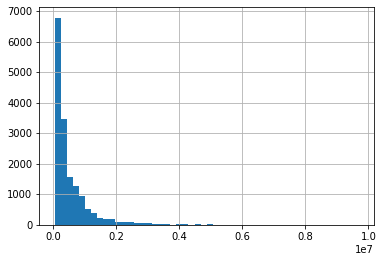

In [28]:
%matplotlib inline

_ = madrid_with_metro_encoded.price.hist(bins=50,)

In [29]:
madrid_with_metro_encoded['log_price'] = np.log( madrid_with_metro_encoded.price )

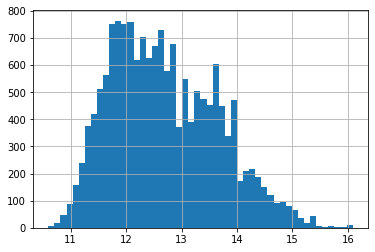

In [30]:
%matplotlib inline

_ = madrid_with_metro_encoded.log_price.hist(bins=50,)

In [31]:
from sklearn.model_selection import train_test_split, KFold

FEATURE_COLUMNS = ["property_state", "distance_to_centre", "distance_to_metro", "mts2"]

x_train, x_test, y_train, y_test = train_test_split(madrid_with_metro_encoded[FEATURE_COLUMNS], madrid_with_metro_encoded["log_price"])

## XGBoost Training

https://xgboost.readthedocs.io/en/latest/parameter.html

In [32]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

params = {
    'objective' : 'reg:linear',
    'tree_method':'auto',
    'min_child_weight' : 2,
    'eta' : 0.2,
    'gamma': 0,
    'max_depth': 5,
    'silent': 1,
    'nthread' : 1,
    #'colsample_bytree': 0.7,
    #'subsample':0.8,
}

hist = xgb.cv(params, dtrain, nfold=3, as_pandas=True, num_boost_round=30, verbose_eval=5, early_stopping_rounds=50)

[0]	train-rmse:9.78997+0.000442688	test-rmse:9.78966+0.0011358
[5]	train-rmse:3.23429+0.000180734	test-rmse:3.23536+0.00376677
[10]	train-rmse:1.11213+0.000632785	test-rmse:1.11347+0.00680494


/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15]	train-rmse:0.475438+0.00116759	test-rmse:0.481381+0.0107357
[20]	train-rmse:0.325315+0.00096333	test-rmse:0.335912+0.0087404
[25]	train-rmse:0.29082+0.00146167	test-rmse:0.304482+0.00830642
[29]	train-rmse:0.28204+0.000626387	test-rmse:0.297073+0.00636477


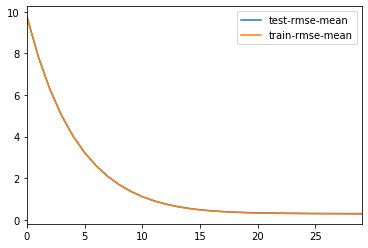

In [33]:
hist.plot(y=["test-rmse-mean", "train-rmse-mean"])

In [34]:
%%time
bst = xgb.train(params, dtrain, num_boost_round=30, verbose_eval=5)

CPU times: user 141 ms, sys: 1.62 ms, total: 143 ms
Wall time: 142 ms


In [35]:
y_preds = bst.predict(dtest)

In [36]:
y_preds_exp = np.exp(y_preds)
y_true_exp = np.exp(y_test)

mse_xgb = sklearn.metrics.mean_squared_error(y_preds_exp, y_true_exp)
rmse_xgb = np.sqrt(mse_xgb)
print(rmse_xgb)

277518.94574047707


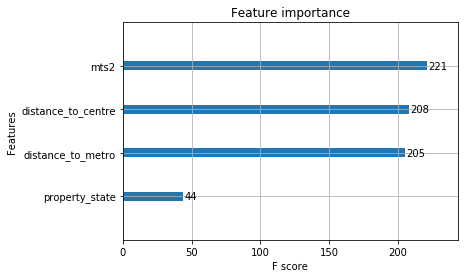

In [37]:
_ = xgb.plot_importance(bst)

## 5. Evaluation

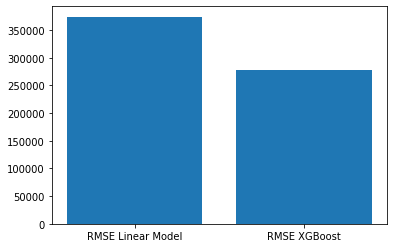

In [38]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(2)
money = [rmse_lm, rmse_xgb]

fig, ax = plt.subplots()

plt.bar(x, money)
plt.xticks(x, ('RMSE Linear Model', 'RMSE XGBoost'))
plt.show()

## Error Analysis - Which houses are difficult to predict ?

In [39]:
#
# Take test test and store clipped absolute error
#
abs_error = np.clip(np.abs(np.exp(y_preds) - np.exp(y_test)),0,250000)


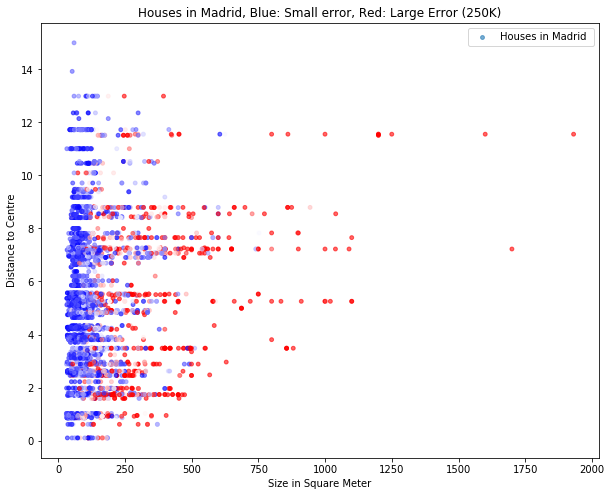

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(x=np.clip(x_test['mts2'],0,2000),alpha=.6,s=15,y=np.clip(x_test['distance_to_centre'],0,15), c=abs_error, cmap='bwr',label="Houses in Madrid ")
plt.title("Houses in Madrid, Blue: Small error, Red: Large Error (250K)")
plt.xlabel('Size in Square Meter')
plt.ylabel('Distance to Centre')
plt.legend()
plt.show()

## Use Watson Machine Learning Service - Store and Deploy the XGBoost Model



#### Authentication - `wml` needs a token to authenticate on CP4D

In [56]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "2.5.0"
}

client = WatsonMachineLearningAPIClient(wml_credentials)

## 6. Model Deployment

https://www.ibm.com/support/producthub/icpdata/docs/content/SSQNUZ_current/wsj/wmls/wmls-deploy-python.html

### Create the Deployment Spacem
Create a new deployment space. Use the name of the space as specified in the user inputs cell above. A default tag for the space is specified in the space metadata. This tag will be used in the future to identify this space. If a space with specified space_name already exists, a new space with the same name is created. Set this deployment space as the default space.

In [57]:
DEPLOYMENT_SPACE_NAME = 'madrid_demo_space'

spaces_details = client.spaces.get_details()

In [58]:
space_uid = None

for space in spaces_details['resources']:
    print(space['metadata']['name'])
    if space['metadata']['name'] == DEPLOYMENT_SPACE_NAME:
        space_uid = space['metadata']['guid']

madrid_demo_space


In [59]:
if space_uid is None:
    space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : DEPLOYMENT_SPACE_NAME,
        client.spaces.ConfigurationMetaNames.TAGS : [{'value':'madrid_houses_space_tag'}]
    }
    stored_space_details = client.spaces.store(space_meta_data)

    space_uid = stored_space_details['metadata']['guid']



In [60]:
client.set.default_space(space_uid)

'SUCCESS'

### Store the Model Details
Store the model in the deployment space. Again, the name for the model is specified in the user inputs cell above. A default tag for the model is specified in the model metadata.


https://www.ibm.com/support/producthub/icpdata/docs/content/SSQNUZ_current/wsj/wmls/wmls-deploy-python-types.html


In [61]:
client.repository.list_models()

----  ----  -------  ----
GUID  NAME  CREATED  TYPE
----  ----  -------  ----


In [62]:
model_details = client.repository.get_model_details()

In [63]:
model_guid = None

model_name = 'madrid_demo_model'

for model_resource in model_details['resources']:
    print(model_resource['metadata'])
    if model_name == model_resource['metadata']['name']:
        model_guid = model_resource['metadata']['guid']

In [64]:
if model_guid == None:
    metadata = {
        client.repository.ModelMetaNames.NAME: model_name,
        client.repository.ModelMetaNames.TYPE: "xgboost_0.82",
        client.repository.ModelMetaNames.RUNTIME_UID: "xgboost_0.82-py3.6",
        client.repository.ModelMetaNames.TAGS: [{'value' : 'customer_segmentation_model_tag', 'model_parameter_gamma' : '1' , 'version' : 3}],
        client.repository.ModelMetaNames.SPACE_UID: space_uid
    }

    stored_model_details = client.repository.store_model(model=bst, meta_props=metadata)
    model_guid = stored_model_details["metadata"]["guid"]
    
    metadata = {
        client.repository.ModelMetaNames.NAME: "Madrid Model V2",
        client.repository.ModelMetaNames.TYPE: "xgboost_0.82",
        client.repository.ModelMetaNames.RUNTIME_UID: "xgboost_0.82-py3.6",
        client.repository.ModelMetaNames.TAGS: [{'value' : 'customer_segmentation_model_tag', 'model_parameter_gamma' : '1' , 'version' : 3}],
        client.repository.ModelMetaNames.SPACE_UID: space_uid
    }

    stored_model_details = client.repository.store_model(model=bst, meta_props=metadata)

### Deploy the Model

Deploy the saved model. The deployment name is specified in the user inputs cell above. Again, a default tag for the deployment is specified in the deployment metadata. Similarly, this tag will be used in the future to identify this deployment.

In [65]:
deployments = client.deployments.get_details()
deployment_name = 'madrid_demo_model_deployment'
deployed = False

for deploy in deployments['resources']:
    print(deploy['entity']['name'])
    if deploy['entity']['name'] == deployment_name:
        deployed = True

In [66]:
if not deployed:
    # deploy the model
    meta_props = {
        client.deployments.ConfigurationMetaNames.NAME: deployment_name,
        client.deployments.ConfigurationMetaNames.TAGS : [{'value' : 'madrid_deployment_tag'}],
        client.deployments.ConfigurationMetaNames.ONLINE: {}
    }


    client.deployments.create(artifact_uid=model_guid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: 'c8d88b4e-bb50-44e6-8997-c55446618ab3' started

#######################################################################################


initializing..................................
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='1c3c6023-0677-4ae6-b087-59512f7e5a66'
------------------------------------------------------------------------------------------------




## Scoring

In [67]:
deployments = client.deployments.get_details()

In [68]:
dep_id = None

for dep in deployments['resources']:
    if deployment_name == dep['metadata']['name']:
        dep_id = dep['metadata']['id']
        


In [69]:
payload_scoring = {"input_data": [{"fields": ["property_state", "distance_to_centre", "distance_to_metro", "mts2"], 
"values": [[1,2.3,.6,120]]}] }

In [70]:
predictions = client.deployments.score(dep_id, payload_scoring) 
print(predictions)

{'predictions': [{'fields': ['prediction', 'probability'], 'values': [[12.79232120513916, 12.79232120513916]]}]}


### Example with requests

In [71]:
dep_id = None
dep_url = None

for dep in deployments['resources']:
    if deployment_name == dep['metadata']['name']:
        dep_id = dep['metadata']['id']
        
        dep_url = dep['entity']['status']['online_url']['url']

In [72]:
dep_url

'https://internal-nginx-svc:12443/v4/deployments/1c3c6023-0677-4ae6-b087-59512f7e5a66/predictions'

In [73]:
import urllib3, requests, json

mltoken = os.environ["USER_ACCESS_TOKEN"]
# NOTE: you must construct mltoken based on provided documentation	
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = payload_scoring

response_scoring = requests.post(dep_url, json=payload_scoring, headers=header)
print("Scoring response")
print(json.loads(response_scoring.text))

Scoring response
{'predictions': [{'fields': ['prediction', 'probability'], 'values': [[12.79232120513916, 12.79232120513916]]}]}
